# GCN Code

### Latex Macros
$\newcommand{\Re}[1]{{\mathbb{R}^{{#1}}}}
\newcommand{\Rez}{{\mathbb{R}}}$

# Starting from First_GNN_simplified.ipynb, transform it to a version using the PyTorch library
* The code will still handle the Karate Club Graph
* Create a function library just for the Karate Club Graph dataset. This library will later be generalized to handle a wide set of data. 
* Eventually, we will use the PyGeometric, but there is lots to learn before that point. 
* [Torch tutorial](https://pytorch.org/tutorials/beginner/pytorch_with_examples.html)

In [1]:
%load_ext autoreload
%autoreload 2
#%tableofcontents

In [92]:
import torch
from torchsummary import summary
import tqdm.auto
from tqdm import tqdm
import os
from collections import defaultdict
import spectral_function_library as speclib
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import karate_function_library as karate

In [7]:
### We use the famous 'Karate Club' network as a test case. Our task is to
### predict the community to which each node belongs; formally, this would be
### called transductive binary node classification.

G = nx.karate_club_graph()

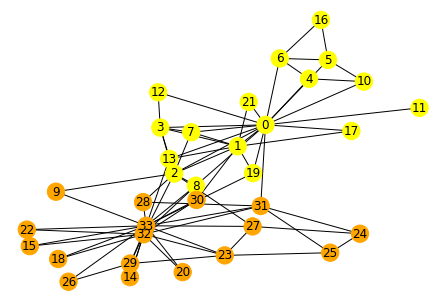

In [ ]:
karate.drawOriginalGraph(G)

# Features

In [61]:
# add nb_features, node_metadata to G
karate.add_gaussian_features(G, means=[0.0, 1.5], std=(1, 1), nb_features=16)

# Plot Metadata histograms

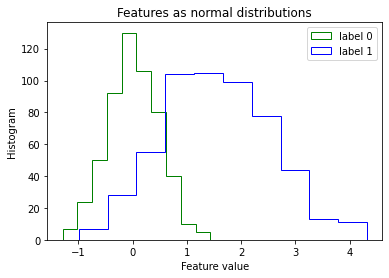

In [51]:
karate.plot_metadata(G)

# Linear model is 
$$ H^{n+1} = A H^n W $$
where $H\in \Re{N\times d}$, $A\in\Re{N\times N}$, and $W\in\Re{d\times d}$ and $d$ is the number of features. In our synthetic example, we have 16 features, one label. `

In [179]:
class MyGCN(torch.nn.Module):
    def __init__(self, G):
        super(MyGCN, self).__init__()
        nb_nodes = G.nb_nodes
        A = nx.linalg.graphmatrix.adjacency_matrix(G).toarray()
        An = np.eye(nb_nodes) + A
        D = np.sum(An, axis=0)  # degree matrix
        Dinvsq = np.diag(np.sqrt(1.0 / D))  # array
        An = Dinvsq @ An @ Dinvsq # symmetric normalization
        self.H0 = G.node_metadata
        self.Y = torch.from_numpy(G.labels)

        # # 0: training set (50%); 1: testing set (50%)
        # # mask = torch.from_numpy(np.random.randint(0, 2, H0.shape[0]))
        # mask = torch.from_numpy(
        #     np.random.choice(2, self.H0.shape[0], p=[frac_train, 1.0 - frac_train])
        # )

        nb_features = G.node_metadata.shape[1]
        print("nb_features: ", nb_features)
        
        self.relu = torch.nn.ReLU();
        self.sigmoid = torch.nn.Sigmoid();
        
        self.W = []
        # I did initialize the weights, but only with non-scaled random numbers
        # self.W.append(torch.rand(nb_features, nb_features, requires_grad=True))
        # sigmoid output layer
        # self.W.append(torch.rand(nb_features, 1, requires_grad=True))  
        self.W0 = torch.nn.Parameter(torch.rand(nb_features, nb_features, requires_grad=True))
        self.W1 = torch.nn.Parameter(torch.rand(nb_features, 1, requires_grad=True))
        
        # Glorot Initialization
        rmax = 1 / nb_features ** 0.5
        torch.nn.init.uniform_(self.W0, -rmax, rmax)
        torch.nn.init.uniform_(self.W1, -rmax, rmax)

        self.An = torch.from_numpy(An).float()

        # The input can be either torch.Tensor or numpy.ndarray
        # if isinstance(self.H, np.ndarray):
        #     self.H = torch.from_numpy(self.H).float()
        if isinstance(self.H0, np.ndarray):
            self.H0 = torch.from_numpy(self.H0).float()
        if isinstance(self.Y, np.ndarray):
            self.Y = torch.from_numpy(self.Y).float()
        if isinstance(self.An, np.ndarray):
            self.An = torch.from_numpy(self.An).float()
            
    def forward(self, H0):
        """
        Semi-supervised GCN, similar to that of Kipf & Welling (2016)
         W : list of weights of different shapes
        """
        # print(type(self.An), type(H0), type(self.W0))
        # print(self.An.dtype, H0.dtype, self.W0.dtype)
        X = self.relu(self.An @ H0 @ self.W0)
        X = self.sigmoid(self.An @ X @ self.W1)
        return X

In [175]:
model = MyGCN(G)

nb_features:  16


In [157]:
print(model)

MyGCN(
  (relu): ReLU()
  (sigmoid): Sigmoid()
)


In [130]:
list(model.parameters());  # Two weight tensors. Note requires_grad=True

In [131]:
class BinaryCrossEntropyLoss:
    def __init__(self, mask):
        self.mask = mask
        
    def __call__(self, hidden, target):
        H = hidden
        Y = target
        """
        summation over all edges
        Training set: defined by mask[i] = 0
        H[i,0] is the probability of Y[i] == 1 (target probability)
        H[i,1] is the probability of Y[i] == 0 (target probability)

        Parameters
        ----------
        target : torch.tensor of shape [nb_nodes, 2]


        Y : torch.tensor of shape [nb_nodes]
            labels

        Notes 
        -----
        The target must be in the range [0,1].
        """
        costf = 0
            
        for i in range(Y.shape[0]):
            if self.mask[i] == 0:  # training set
                costf -= (Y[i] * torch.log(H[i,0]) + (1-Y[i]) * torch.log(1.-H[i,0]))

        return costf

In [195]:
def train(A, H, H0, Y, W, mask, nb_epochs, activation, lr=1.0e-2):

    # Follow https://www.analyticsvidhya.com/blog/2021/08/linear-regression-and-gradient-descent-in-pytorch/

    accuracy_count = defaultdict(list)
    loss = [cost(H0, Y, mask, activation)]

    for epoch in tqdm(range(nb_epochs)):
        H = model(A, H0, W)
        costf = cost(H, Y, mask, activation)
        loss.append(costf.item())

        if np.isnan(costf.detach().item()):
            print("costf is NaN")
            break
        with torch.no_grad():
            costf.backward(retain_graph=False)
            for w in W:
                w -= lr * w.grad
                w.grad.zero_()

        if epoch % 100 == 0:
            predict(
                A, H0, Y, W, mask, activation="sigmoid", accuracy_count=accuracy_count
            )
            pass

    return loss, accuracy_count

In [196]:
def predict(A, H0, Y, W, mask, activation, accuracy_count):
    
    # Follow https://www.analyticsvidhya.com/blog/2021/08/linear-regression-and-gradient-descent-in-pytorch/
    H = model(A, H0, W)
    
    if activation == "relu":
        count = [0,0]
        count_correct = [0,0]
        for i in range(H.shape[0]):
            if mask[i] == 1:
                count[0] += 1
                if H[i,0] > 0.5 and Y[i] > 0.9:
                    count_correct[0] += 1
                elif H[i,1] < 0.5 and Y[i] < 0.1:
                    count_correct[1] += 1
        perc0_corr = count_correct[0] / count[0]
        perc1_corr = count_correct[1] / count[0]
        print("sum(H): ", torch.sum(H, axis=0))
        print("Perc (%) class 0/1 correct: ", perc0_corr, perc1_corr)
    elif activation == "sigmoid":    # <<<< CASE BEING USED (2022-02-03)
        count_correct = [0,0]
        count = [0,0]
        for i in range(H.shape[0]):
            if mask[i] == 1: # test data
                count[1] += 1
                if H[i] > 0.5 and Y[i] > 0.9:
                    count_correct[1] += 1
                if H[i] < 0.5 and Y[i] < 0.1:
                    count_correct[1] += 1
            else:  # mask == 0, training data
                count[0] += 1
                if H[i] > 0.5 and Y[i] > 0.9:
                    count_correct[0] += 1
                if H[i] < 0.5 and Y[i] < 0.1:
                    count_correct[0] += 1

        accuracy_count['train'].append(count_correct[0] / count[0])
        accuracy_count['test'].append(count_correct[1] / count[1])
    else:
        print("predict(): Incorrect activation function")
        return

## Observations
By default, the features are two normal distributions (16 values per node, so there are 16 features). 
One Gaussian is placed over its appropriate label (there are two labels). With 16 features, I experiment with the fraction of nodes in the training set. I choose a fraction `frac_train` of the nodes as the training set. 

When `frac_train` goes to 0.05, there are very few nodes in the training set. However, as long is there is at least one node of each type, I get good test accuracy. 

For a given value of `frac_train`, testing accuracy goes down as I decrease the number of features. In the limit of a single feature, there is not enough information to distinguish the two distributions, and accuracy decreases.

To further test the code with 16 features, I permute the attributes amongst the nodes. Now, the two Gaussians no longer match the two labels in the graph. The label prediction  accuracy goes down substantially, ending up closer to 50% accuracy, which is random. 

One can also use structural information for features, such as node degree. I would not expect great accuracy in that case. 

In the cell that follows, feature_type is `None` specifies the two Gaussians centered at 0 and 1. If `feature_type` is `degree`, use the node degree as the single feature. The accuracy of the testing is quite low in that case. Sometimes I get zero accuracy on training and testing data, and sometimes I get about 50% on both. I do NOT know why I get zero accuracy when `frac_train=0.5`. Seems unlikely. When `frac_train=0.8`, I sometimes get zero, and sometimes 0.55 on training set and 0.2 on testing set. Obviously, the degree is a poor choice for a feature as it seems decorrelated from the labels. Note also, that I divided the degree by the maximum degree over the graph to keep it in the range `[0,1]`.

In [158]:
# 0: training set (50%); 1: testing set (50%)
# mask = torch.from_numpy(np.random.randint(0, 2, H0.shape[0]))
frac_train = 0.5
mask = torch.from_numpy(
    np.random.choice(2, G.nb_nodes, p=[frac_train, 1.0 - frac_train])
)

loss_fn = BinaryCrossEntropyLoss(mask)

optimizer = torch.optim.SGD(model.parameters(), lr=1.e-3)
#optim = torch.optim.Adam(model.parameters(), lr=0.001)

In [220]:
# Using new torch functionality

#### ERROR: Parameters are not updating! WHY? 

def new_train(G, model, loss_fn, optimizer):
    model.train()
    H0 = torch.tensor(G.node_metadata).float()
    
    for epoch in range(5):
        pred = model(H0)
        loss = loss_fn(pred, G.labels)
        loss.backward()
        # print(type(G.labels), type(pred))
        print("loss: ", loss.item())
        optimizer.zero_grad()
        optimizer.step()
        print(list(model.parameters())[0][2,2].item())
        # cost = optimizer(pred, G.labels)

In [221]:
new_train(G, model, loss_fn, optimizer)

<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.nn.parameter.Parameter'>
torch.float32 torch.float32 torch.float32
loss:  11.922792434692383
0.21551483869552612
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.nn.parameter.Parameter'>
torch.float32 torch.float32 torch.float32
loss:  11.922792434692383
0.21551483869552612
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.nn.parameter.Parameter'>
torch.float32 torch.float32 torch.float32
loss:  11.922792434692383
0.21551483869552612
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.nn.parameter.Parameter'>
torch.float32 torch.float32 torch.float32
loss:  11.922792434692383
0.21551483869552612
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.nn.parameter.Parameter'>
torch.float32 torch.float32 torch.float32
loss:  11.922792434692383
0.21551483869552612


In [197]:
A, H, H0, Y, W, mask = model_setup(G, frac_train=0.8, nb_features=8, feature_type=None)
print("H: ", H.shape)
print("H0: ", H0.shape, type(H0))
print("nb_features: ", H.shape[1])
index = torch.where(mask == 0, True, False)
print("labels where mask == 0: ", Y[index])
loss, accuracy_count = train(A, H, H0, Y, W, mask, nb_epochs=1400, activation="sigmoid")

# When running frac_train=0.05 (0.05 * 34 = 1.7), I sometimes get 0, 1, or 2 0 masks. 
# When there are 0 training labels, I get an error
# When there is 1 training label, I get 50% error, i.e., 50% accuracy (random)
# When there are 2 training labels, I get close to 100% accuracy

type(H0) not handled:  <class 'numpy.ndarray'>
return from set_model, types: 
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'> <class 'list'> <class 'torch.Tensor'>
H:  torch.Size([34, 8])
H0:  torch.Size([34, 8]) <class 'torch.Tensor'>
nb_features:  8
labels where mask == 0:  tensor([0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1,
        1])


  0%|          | 0/1400 [00:00<?, ?it/s]/Users/erlebach/opt/anaconda3/envs/torch/lib/python3.8/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 1400/1400 [00:03<00:00, 379.99it/s]


gordon


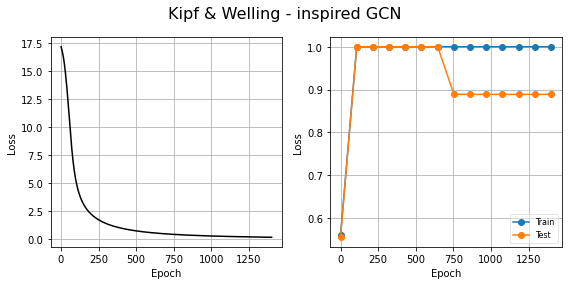

In [198]:
fig, axes = plt.subplots(1, 2, figsize=(8,4))
plt.suptitle("Kipf & Welling - inspired GCN", fontsize=16)
speclib.plot_one_curve(axes[0], loss, xlabel='Epoch', ylabel='Loss', style='-', title='')

y = np.asarray([v for k,v in accuracy_count.items()]).T  # shape: [N, 2]  
x = np.linspace(0, y.shape[0]*100, y.shape[0])
speclib.plot_multi_curves(axes[1], x, y, xlabel='Epoch', ylabel='Loss', title='', labels=['Train', 'Test'])

plt.tight_layout()
plt.show()

# Decoupling attributes/labels from structure
The question is: how important is the structural information? To determine that, we keep the graph fixed, but shuffle the labels across the graph nodes:
The number of each label will remain the same, but the labels, together with the attributes, will migrate to different nodes. 
Therefore, the edge connections  are no longer related to the edges. In that situation, one expects labelling accuracy to go down. 

This is accomplished by reshuffling the rows of `graph.node_metadata`. So first create a node permutation. 

In [199]:
A, H, H0, Y, W, mask = model_setup(G, frac_train=0.05) 

type(H0) not handled:  <class 'numpy.ndarray'>
return from set_model, types: 
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'> <class 'list'> <class 'torch.Tensor'>


In [200]:
perm_nodes = torch.randperm(G.nb_nodes)
print("perm_nodes: ", perm_nodes)
print("H0.shape: ", H0.shape)
print(type(H0))
H0 = H0[perm_nodes]
print("H0.shape: ", H0.shape)

perm_nodes:  tensor([ 6, 25, 13, 21, 11, 10, 16, 19, 26, 17,  5, 31, 20,  3, 33, 30,  1, 18,
        28, 12,  9, 15,  2, 24,  8, 27,  4, 22, 29,  7, 23, 32, 14,  0])
H0.shape:  torch.Size([34, 16])
<class 'torch.Tensor'>
H0.shape:  torch.Size([34, 16])


In [212]:
A, H, H0, Y, W, mask = model_setup(G, frac_train=.2, H0=H0) 
index = torch.where(mask == 0, True, False)
loss, accuracy_count = train(A, H, H0, Y, W, mask, nb_epochs=5501, activation="sigmoid", lr=1.e-4)

return from set_model, types: 
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'> <class 'list'> <class 'torch.Tensor'>


100%|██████████| 5501/5501 [00:06<00:00, 894.49it/s]


gordon


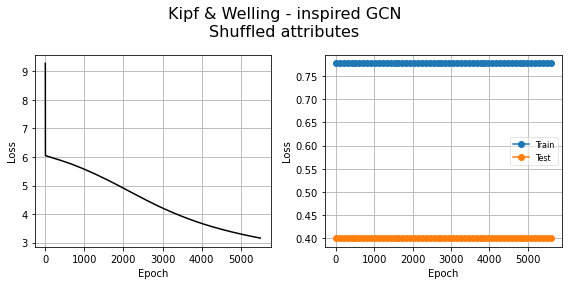

In [216]:
fig, axes = plt.subplots(1, 2, figsize=(8,4))
plt.suptitle("Kipf & Welling - inspired GCN\nShuffled attributes", fontsize=16)
speclib.plot_one_curve(axes[0], loss, xlabel='Epoch', ylabel='Loss', style='-', title='')

y = np.asarray([v for k,v in accuracy_count.items()]).T  # shape: [N, 2]  
x = np.linspace(0, y.shape[0]*100, y.shape[0])
speclib.plot_multi_curves(axes[1], x, y, xlabel='Epoch', ylabel='Loss', title='', labels=['Train', 'Test'])

plt.tight_layout()
plt.show()

## Observations
* When I shuffled the features to decorrelate them with respect to the labels, the loss function decreases rather differently than before. WHY? 